In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

def plot_numeric(df, feature, label_col="label"):
    weights = df.groupby(label_col)[feature].transform(lambda x: 1 / len(x))

    plt.figure(figsize=(8, 5))
    sns.histplot(
        data=df,
        x=feature,
        hue=label_col,
        bins=50,
        weights=weights,
        alpha=0.6
    )
    plt.title(f"{feature} by {label_col} (normalized)")
    plt.ylabel("Relative frequency")
    plt.show()


def plot_boolean(df, feature, label_col="label"):
    prop_df = (
        df
        .groupby(label_col)[feature]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=prop_df,
        x=feature,
        y="proportion",
        hue=label_col
    )
    plt.title(f"{feature} by {label_col}")
    plt.ylabel("Proportion")
    plt.show()

In [3]:
import re
from emoji import demojize
from nltk.tokenize import TweetTokenizer

USER_PATTERN = r"(?<!\w)@[A-Za-z0-9_]{1,15}\b"
URL_PATTERN = r"(https?://[^\s]+|www\.[^\s]+)"
EMAIL_PATTERN = r"\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b"

tokenizer = TweetTokenizer()

def normalize_entities(text):
  if not isinstance(text, str) or text.strip() == "":
    return text
  
  text = re.sub(EMAIL_PATTERN, "<EMAIL>", text)
  text = re.sub(URL_PATTERN, "<URL>", text)
  text = re.sub(USER_PATTERN, "<USER>", text)

  return text

def normalize_token(token):
    token = token.replace("’", "'").replace("…", "...")

    if token == "<USER>":
        return "@USER"
    if token == "<URL>":
        return "HTTPURL"
    if len(token) == 1:
        return demojize(token)

    return token

def normalize_text(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""

    text = text.strip()
    text = normalize_entities(text)

    tokens = tokenizer.tokenize(text)
    norm_tweet = " ".join(normalize_token(t) for t in tokens)

    # contractions
    norm_tweet = (
        norm_tweet.replace("cannot ", "can not ")
                  .replace(" n't ", " n't ")
                  .replace("ca n't", "can't")
                  .replace("ai n't", "ain't")
    )

    # verb contractions
    norm_tweet = (
        norm_tweet.replace(" 'm ", " 'm ")
                  .replace(" 're ", " 're ")
                  .replace(" 's ", " 's ")
                  .replace(" 'll ", " 'll ")
                  .replace(" 'd ", " 'd ")
                  .replace(" 've ", " 've ")
    )

    # time expressions
    norm_tweet = (
        norm_tweet.replace(" p . m .", " p.m.")
                  .replace(" p . m ", " p.m ")
                  .replace(" a . m .", " a.m.")
                  .replace(" a . m ", " a.m ")
    )

    return " ".join(norm_tweet.split())

In [4]:
import torch
from sklearn.base import BaseEstimator, TransformerMixin
from transformers import AutoModel, AutoTokenizer
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SentenceEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="vinai/bertweet-base"):
      self.model_name = model_name
      self.model = AutoModel.from_pretrained(self.model_name)
      self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
      self.model.to(device)
      self.model.eval()

    def fit(self, X, y=None):
      return self

    def transform(self, X):
      if isinstance(X, pd.Series):
        X = X.values

      out = np.empty((len(X), 1), dtype=object)
      batch_size = 1024

      loader = DataLoader(
          X,
          batch_size=batch_size,
          shuffle=False
          )
      embeddings = []

      with torch.no_grad():
        for batch in tqdm(loader, desc="Embedding text"):
          inputs = self.tokenizer(
              batch,
              padding=True,
              truncation=True,
              max_length=64,
              return_tensors="pt"
              )
          inputs = {k: v.to(device) for k, v in inputs.items()}  # move tensors to GPU

          outputs = self.model(**inputs)
          batch_embeddings = outputs.last_hidden_state[:, 0, :]  # (n_samples, 768)
          embeddings.append(batch_embeddings.cpu())

      embeddings = torch.cat(embeddings, dim=0)  # shape: (N, 768)
      out[:, 0] = list(embeddings.numpy())  # each row is a 768-D array

      torch.cuda.empty_cache()
      return out

d:\Studies\Materials\Second-cycle\II year\II trimester\Thesis\thesis\thesis-venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import joblib

user_features = joblib.load(f"../../02_data/user_features_1.joblib")
tweet_features = joblib.load(f"../../02_data/tweet_features_1.joblib")

In [6]:
tweet_features.head()

,author_id,id,text,created_at,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,label,tweet_is_present,tweet_length,tweet_num_words,tweet_num_sentences,tweet_avg_sentence_length,tweet_avg_word_length,tweet_std_word_length,tweet_unique_word_ratio,tweet_guiraud_index,tweet_repetition_ratio,tweet_hapax_ratio,tweet_digit_ratio,tweet_uppercase_ratio,tweet_lowercase_ratio,tweet_special_char_ratio,tweet_punctuation_ratio,tweet_whitespace_ratio,tweet_emoji_count,tweet_emoji_ratio,tweet_mention_count,tweet_contains_mention,tweet_url_count,tweet_contains_url,tweet_hashtag_count,tweet_cashtag_count,tweet_email_count,tweet_contains_bot_word_or_hashtag,tweet_contains_ai_hashtag,tweet_sentiment,tweet_sentiment_abs,tweet_sentiment_neutrality,tweet_sentiment_subjectivity,tweet_flesch_reading_ease,tweet_flesch_kincaid_grade,tweet_avg_syllables_per_word,tweet_polysyllabic_word_ratio,tweet_char_entropy,tweet_word_entropy,tweet_avg_word_repetition,tweet_compression_ratio,tweet_starts_with_emoji,tweet_ends_with_emoji,tweet_starts_with_url,tweet_ends_with_url,tweet_contains_pipe_or_bullet,tweet_contains_call_to_action,tweet_contains_ai_phrase,tweet_function_word_ratio,tweet_noun_ratio,tweet_verb_ratio,tweet_pronoun_ratio,tweet_adjective_ratio,tweet_contains_repeated_chars,tweet_is_retweet,tweet_is_quote
0,u1001495628738957312,t1502310945158275074,"Join us for a special screening of the documentary #SAPELO and a Q&amp;A with the filmmakers on Thursday, March 31 at the @CarterCenter!📽️🇨🇭 @CarterLibrary @SWISS_FILMS https://t.co/53nsRtRI8u",2022-03-11 15:50:15+00:00,0,0,1,0.0,0.0,1,0,True,153,27,1,27.0,4.037037,2.714590,0.777778,4.041452,0.222222,0.666667,0.013072,0.238532,0.761468,0.111111,0.084967,0.163399,1,0.006536,3,True,1,True,1,0,0,False,False,0.6360,0.6360,0.3640,0.285714,63.486154,7.633846,1.538462,0.074074,4.914588,4.226567,1.285714,0.986928,False,False,False,True,False,True,False,0.407407,0.370370,0.037037,0.037037,0.111111,False,False,False
1,u1002590470097154048,t1459274835377500161,Looking forward to meeting the final chapter👀👀 https://t.co/6NsqPBe272,2021-11-12 21:40:07+00:00,0,0,0,NaN,NaN,0,1,True,52,7,1,7.0,4.857143,2.030381,1.000000,2.645751,0.000000,1.000000,0.000000,0.097561,0.902439,0.076923,0.038462,0.134615,2,0.038462,0,False,1,True,0,0,0,False,False,0.0000,0.0000,1.0000,1.000000,61.240000,6.705000,1.625000,0.000000,4.302920,2.807355,1.000000,1.173077,False,False,False,True,False,False,False,0.285714,0.142857,0.285714,0.000000,0.142857,False,False,False
2,u1002590470097154048,t1405835036847443969,"RT @HamidrezaKasaei: Our new service robot is getting ready to be used in amazing researches on ""generalizable perception and manipulation…",2021-06-18 10:29:26+00:00,0,0,0,NaN,NaN,1,1,True,129,19,1,19.0,4.894737,3.193657,1.000000,4.358899,0.000000,1.000000,0.000000,0.066667,0.933333,0.038760,0.031008,0.147287,0,0.000000,1,True,0,False,0,0,0,False,False,0.7430,0.7430,0.2570,0.618182,17.335000,15.810000,2.000000,0.263158,4.385255,4.247928,1.000000,0.899225,False,False,False,False,False,False,False,0.315789,0.263158,0.210526,0.052632,0.210526,False,True,False
3,u1002590470097154048,t1401642372044296199,"RT @yao_weijia: I'm happy to be a finalist for the ICRA Best Paper Award &amp; grateful to coauthors @HectorGdeMarina, Zhiyong, @MingCao10. I t…",2021-06-06 20:49:17+00:00,0,0,0,NaN,NaN,3,1,True,125,22,2,11.0,3.954545,2.285871,0.818182,3.837613,0.181818,0.681818,0.000000,0.269663,0.730337,0.112000,0.104000,0.176000,0,0.000000,3,True,0,False,0,0,0,False,False,0.9371,0.9371,0.0629,0.650000,54.750870,11.336522,1.521739,0.090909,4.795863,4.061482,1.222222,0.976000,False,False,False,False,False,False,False,0.272727,0.454545,0.090909,0.000000,0.136364,False,True,False
4,u1002590470097154048,t1379337484384014336,"RT @corl_conf: The Conference on #Robot #Learning 2021 will be held on Nov 8-11 in London, UK &amp; virtually. Exciting new changes, including:…",2021-04-06 07:37:37+00:00,0,0,0,NaN,NaN,44,1,True,140,21,2,10.5,4.66

In [7]:
if tweet_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
                               Missing Count  Missing Percentage
quote_count                           796093           75.899847
reply_count                           796093           75.899847
tweet_avg_word_length                     25            0.002384
tweet_std_word_length                     25            0.002384
tweet_unique_word_ratio                   25            0.002384
tweet_guiraud_index                       25            0.002384
tweet_repetition_ratio                    25            0.002384
tweet_hapax_ratio                         25            0.002384
tweet_uppercase_ratio                      2            0.000191
tweet_lowercase_ratio                      2            0.000191
tweet_polysyllabic_word_ratio             25            0.002384
tweet_word_entropy                        25            0.002384
tweet_avg_word_repetition                 25            0.002384
tweet_function_word_ratio

In [ ]:
tweet_features['quote_count_missing'] = tweet_features['quote_count'].isnull().astype(bool)
tweet_features['reply_count_missing'] = tweet_features['reply_count'].isnull().astype(bool)

zero_fill = [
    "quote_count",
    "reply_count",
    "tweet_unique_word_ratio",
    "tweet_repetition_ratio",
    "tweet_hapax_ratio",
    "tweet_uppercase_ratio",
    "tweet_lowercase_ratio",
    "tweet_polysyllabic_word_ratio",
    "tweet_word_entropy",
    "tweet_function_word_ratio",
    "tweet_noun_ratio",
    "tweet_verb_ratio",
    "tweet_pronoun_ratio",
    "tweet_adjective_ratio"
]

median_fill = [
    "tweet_avg_word_length",
    "tweet_std_word_length",
    "tweet_guiraud_index",
    "tweet_avg_word_repetition"
]

tweet_features[zero_fill] = tweet_features[zero_fill].fillna(0)
tweet_features[median_fill] = tweet_features[median_fill].apply(
    lambda x: x.fillna(x.median())
)

In [9]:
if tweet_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [10]:
for col, dtype in tweet_features.dtypes.items():
    print(f"{col}: {dtype}")

author_id: object
id: object
text: object
created_at: object
is_reply: int32
is_sensitive: int32
like_count: int64
quote_count: float64
reply_count: float64
retweet_count: int64
label: int64
tweet_is_present: bool
tweet_length: int64
tweet_num_words: int64
tweet_num_sentences: int64
tweet_avg_sentence_length: float64
tweet_avg_word_length: float64
tweet_std_word_length: float64
tweet_unique_word_ratio: float64
tweet_guiraud_index: float64
tweet_repetition_ratio: float64
tweet_hapax_ratio: float64
tweet_digit_ratio: float64
tweet_uppercase_ratio: float64
tweet_lowercase_ratio: float64
tweet_special_char_ratio: float64
tweet_punctuation_ratio: float64
tweet_whitespace_ratio: float64
tweet_emoji_count: int64
tweet_emoji_ratio: float64
tweet_mention_count: int64
tweet_contains_mention: bool
tweet_url_count: int64
tweet_contains_url: bool
tweet_hashtag_count: int64
tweet_cashtag_count: int64
tweet_email_count: int64
tweet_contains_bot_word_or_hashtag: bool
tweet_contains_ai_hashtag: bool
tw

In [11]:
tweet_features["created_at"] = pd.to_datetime(
    tweet_features["created_at"],
    errors="coerce",
    utc=True
)

bool_cols = ["is_reply", "is_sensitive"]
int_cols = ["quote_count", "reply_count"]

tweet_features[bool_cols] = tweet_features[bool_cols].astype("bool")
tweet_features[int_cols] = tweet_features[int_cols].astype("int64")

In [12]:
tweet_features["tweet_hour"] = tweet_features["created_at"].dt.hour
tweet_features["tweet_day_of_week"] = tweet_features["created_at"].dt.dayofweek
tweet_features["tweet_is_weekend"] = tweet_features["tweet_day_of_week"].isin([5, 6]).astype(int)

tweet_features["tweet_hour_sin"] = np.sin(2 * np.pi * tweet_features["tweet_hour"] / 24)
tweet_features["tweet_hour_cos"] = np.cos(2 * np.pi * tweet_features["tweet_hour"] / 24)

tweet_features["tweet_dow_sin"] = np.sin(2 * np.pi * tweet_features["tweet_day_of_week"] / 7)
tweet_features["tweet_dow_cos"] = np.cos(2 * np.pi * tweet_features["tweet_day_of_week"] / 7)

tweet_features = tweet_features.sort_values(["author_id", "created_at"])

tweet_features["tweet_time_delta_sec"] = (
    tweet_features
    .groupby("author_id")["created_at"]
    .diff()
    .dt.total_seconds()
)

tweet_features["tweet_time_delta_log"] = np.log1p(tweet_features["tweet_time_delta_sec"])

In [48]:
test = tweet_features.head(50).copy()

test["text_normalized"] = test["text"].apply(normalize_text)

embedder = SentenceEmbedder()
test["text_embedding"] = embedder.transform(test["text_normalized"])[:, 0]

Embedding text: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


In [49]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def cosine_sim(a, b):
    if not isinstance(a, np.ndarray) or not isinstance(b, np.ndarray):
        return np.nan
    return cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0, 0]

In [50]:
test["prev_embedding"] = (
    test
    .groupby("author_id")["text_embedding"]
    .shift(1)
)

test["tweet_cosine_sim_prev"] = test.apply(
    lambda row: cosine_sim(row["text_embedding"], row["prev_embedding"]),
    axis=1
)

user_centroids = (
    test
    .groupby("author_id")["text_embedding"]
    .apply(lambda x: np.mean(np.vstack(x), axis=0))
)

test = test.join(
    user_centroids.rename("user_embedding_centroid"),
    on="author_id"
)

test["tweet_cosine_sim_centroid"] = test.apply(
    lambda row: cosine_sim(
        row["text_embedding"], row["user_embedding_centroid"]
    ),
    axis=1
)

test[["author_id", "created_at", "text_embedding", "prev_embedding", "tweet_cosine_sim_prev", "user_embedding_centroid", "tweet_cosine_sim_centroid"]].head(2)

,author_id,created_at,text_embedding,prev_embedding,tweet_cosine_sim_prev,user_embedding_centroid,tweet_cosine_sim_centroid
332801,u1000016040288555009,2022-03-13 09:31:05+00:00,"[-0.119410746, 0.058532007, 0.1725556, -0.028360642, 0.15765268, -0.18072471, -0.042177357, -0.17201781, 0.029568605, -0.1169146, 0.069233336, 0.19545609, 0.0073506515, 0.11604591, 0.14582667, -0.17512569, 0.04759941, 0.013559291, 0.31509233, 0.17564954, -0.10338326, -0.660424, -0.12663043, -0.0804311, 0.026625603, -0.080531605, -0.04135123, -0.1705904, -0.008618671, 0.22808954, 0.18257004, 0.1033435, -0.6032968, -0.15333553, 0.29531682, -0.1010391, 0.079147324, 0.24490148, 0.22891353, 0.109085664, 0.077361606, -0.3200415, 0.013877856, -0.09069981, 0.2731905, -0.10090698, 0.10046412, -0.2561273, 0.23512217, 0.024687199, 0.13947271, 0.4049219, 0.11896522, 0.12808786, -0.10311535, -0.8007836, 0.028878726, 0.35527566, 0.43170694, 0.31065553, -0.031728707, -0.07488464, 0.39326113, -0.03866022, 0.5285747, 0.25171426, -0.017212898, -0.35148874, 0.12495316, 0.20106646, -0.44787747, -0.54511, 0.20814951, 0.090862334, -0.37193185, -0.14631227, 0.10372982, -0.025133718, -0.18204504, -0.39916196, -0.016766988, -0.16734813, 0.011002765, 0.2383466, -0.039313972, -0.27837783, -0.011167623, 0.21608956, 0.15670434, 0.07840633, 0.23652351, 0.34554887, 0.0290806, -0.310527, -0.291107, 0.065729715, 0.05872382, -0.13825691, -0.33748975, 0.31750026, ...]",NaN,NaN,"[-0.031687576, 0.16973126, 0.1775924, -0.068321414, 0.12034645, -0.10641575, 0.036169905, -0.15100251, 0.03288574, -0.18242264, 0.056194633, 0.10330939, -0.07688057, 0.086045, -0.053691752, -0.14192256, 0.06231334, 0.09000231, 0.37342262, 0.2649021, -0.003834837, -0.7787506, -0.14673159, -0.15377837, 0.025780829, -0.053957734, -0.060575556, -0.09526262, -0.03718429, 0.0705062, 0.14670002, 0.25298002, -0.48521984, -0.13893913, 0.28309208, -0.072772376, 0.012448361, 0.26703393, 0.3307824, 0.06537935, 0.13852812, -0.2560029, 0.12562224, -0.14862666, 0.21266907, -0.084543414, 0.14772008, -0.11148034, 0.27271417, 0.063721426, 0.13791941, 0.31396306, 0.083973095, 0.12460976, -0.067289084, -0.5796032, -0.08489298, 0.40179792, 0.49705687, 0.20225483, -0.07953246, -0.046087682, 0.41357702, 0.09199308, 0.47815302, 0.14950451, 0.026464432, -0.2618357, 0.034165584, 0.26476124, -0.3932227, -0.46660498, 0.07739218, 0.16896205, -0.35190877, -0.16960678, 0.05612225, 0.12677261, -0.10673466, -0.14488111, -0.07331781, -0.105451465, -0.034947187, 0.14232227, 7.785484e-05, -0.16203117, 0.06514077, 0.23351364, 0.14038166, 0.067170896, 0.28422502, 0.20654413, 0.015136905, -0.28779233, -0.014011413, 0.13442351, -0.050206516, -0.081929006, -0.32346767, 0.37424362, ...]",0.967217
332800,u1000016040288555009,2022-03-13 09:31:14+00:00,"[0.06626881, 0.16849771, 0.2947619, -0.1351228, 0.15336522, -0.113072485, 0.01900753, -0.14460102, 0.17963561, -0.22432014, 0.01634632, 0.09177153, -0.1255165, 0.10302861, -0.03316635, -0.07855189, 0.0791913, -0.0072435234, 0.27027047, 0.26462904, 0.07913397, -0.7819196, -0.12668952, -0.15403074, 0.0035051554, -0.07845191, -0.11606979, -0.10352899, -0.03548269, 0.031107984, 0.107471325, 0.2333878, -0.47790486, -0.26078585, 0.2707278, -0.033600114, -0.04204498, 0.31786597, 0.3567572, -0.023792043, 0.15999149, -0.15097447, 0.104039766, -0.15838856, 0.20846534, -0.08322493, 0.09606196, -0.16020225, 0.21274386, 0.041523207, 0.21823749, 0.17113961, -0.028213829, 0.15617763, -0.02708748, -0.5569515, -0.1752854, 0.41160244, 0.50995004, 0.2226975, -0.11601582, -0.11343847, 0.39921975, 0.018372912, 0.44746494, 0.1333938, 0.13706926, -0.26605493, 0.031981915, 0.296942, -0.28590465, -0.3944225, 0.096883945, 0.10126943, -0.38864228, -0.12169203, 0.07233226, 0.12501799, 0.010933861, -0.14963965, -0.09212341, -0.044535182, -0.04680381, 0.20999543, 0.027183741, -0.18169591, -0.054798633, 0.18951267, 0.2153872, 0.06182989, 0.25136533, 0.14035341, 0.09373102, -0.3930997, -0.0026382133, 0.08871824, 0.06711236, -0.12000921, -

In [ ]:
leakage_cols = [
    "tweet_is_present",  # optionally drop these
    "quote_count_missing",
    "reply_count_missing"
]

#test = test.drop(columns=leakage_cols)

In [63]:
import numpy as np

def entropy(x):
    counts = x.value_counts(normalize=True)
    return -(counts * np.log(counts)).sum()

def pct_within_threshold(x, threshold):
    x = x.dropna()
    if len(x) == 0:
        return 0.0
    return (x <= threshold).mean()

from sklearn.linear_model import LinearRegression
import numpy as np

def sentiment_slope(group):
    if len(group) < 2:
        return np.nan

    t = (
        group["created_at"] - group["created_at"].min()
    ).dt.total_seconds().values.reshape(-1, 1)

    y = group["tweet_sentiment"].values

    model = LinearRegression()
    model.fit(t, y)
    return model.coef_[0]

In [74]:
user_weekend_ratio = (
    test
    .groupby("author_id")["tweet_is_weekend"]
    .mean()
    .rename("weekend_post_ratio")
)

user_mean_hour = (
    test
    .groupby("author_id")["tweet_hour"]
    .mean()
    .rename("mean_posting_hour")
)

user_hour_std = (
    test
    .groupby("author_id")["tweet_hour"]
    .std()
    .rename("posting_hour_std")
)

user_hour_entropy = (
    test
    .groupby("author_id")["tweet_hour"]
    .apply(entropy)
    .rename("posting_hour_entropy")
)

user_dow_entropy = (
    test
    .groupby("author_id")["tweet_day_of_week"]
    .apply(entropy)
    .rename("posting_dow_entropy")
)

user_temporal_features = pd.concat(
    [
        user_weekend_ratio,
        user_mean_hour,
        user_hour_std,
        user_hour_entropy,
        user_dow_entropy
    ],
    axis=1
)

user_temporal_features = user_temporal_features.fillna(0)

test = test.sort_values(
    ["author_id", "created_at"]
)

user_delta_stats = (
    test
    .groupby("author_id")["tweet_time_delta_sec"]
    .agg(
        delta_mean="mean",
        delta_median="median",
        delta_std="std",
        delta_min="min"
    )
)

user_delta_stats["delta_burstiness"] = (
    user_delta_stats["delta_std"] /
    user_delta_stats["delta_mean"]
)

user_fast_posting = (
    test
    .groupby("author_id")["tweet_time_delta_sec"]
    .agg(
        pct_within_10s=lambda x: pct_within_threshold(x, 10),
        pct_within_60s=lambda x: pct_within_threshold(x, 60),
        pct_within_5min=lambda x: pct_within_threshold(x, 300),
    )
)

user_intertweet_features = pd.concat(
    [user_delta_stats, user_fast_posting],
    axis=1
)

user_intertweet_features = (
    user_intertweet_features
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)

user_semantic_features = (
    test
    .groupby("author_id")["tweet_cosine_sim_centroid"]
    .agg(["mean", "max", "std"])
    .rename(columns={
        "mean": "sem_centroid_sim_mean",
        "max": "sem_centroid_sim_max",
        "std": "sem_centroid_sim_std"
    })
)

user_embedding_mean = (  # the same as user_centroids
    test
    .groupby("author_id")["text_embedding"]
    .apply(lambda x: np.mean(np.vstack(x), axis=0))
    .rename("embedding_mean")
)

user_embedding_std = (
    test
    .groupby("author_id")["text_embedding"]
    .apply(lambda x: np.std(np.vstack(x), axis=0))
    .rename("embedding_std")
)

user_embedding_std_mean = (  # embedding_std collapsed to one value (mean)
    user_embedding_std
    .apply(lambda x: x.mean())
    .rename("embedding_std_mean")
)

user_embedding_features = pd.concat(
    [
        user_embedding_std_mean
    ],
    axis=1
)

user_activity = (
    test
    .groupby("author_id")
    .agg(
        retweet_to_tweet_ratio=("tweet_is_retweet", "mean"),
        reply_to_tweet_ratio=("is_reply", "mean"),
        quote_to_tweet_ratio=("tweet_is_quote", "mean"),
    )
)

user_readability_std = (
    test
    .groupby("author_id")["tweet_flesch_reading_ease"]
    .std()
    .rename("readability_std_over_time")
)

user_sentiment_slope = (
    test
    .groupby("author_id")
    .apply(sentiment_slope)
    .rename("sentiment_time_slope")
)

tweet_rate = (
    test
    .groupby("author_id")
    .size()
    .rename("n_tweets")
)

account_span_days = (
    test
    .groupby("author_id")["created_at"]
    .agg(lambda x: (x.max() - x.min()).days + 1)
    .rename("active_days")
)

user_tweet_rate = (tweet_rate / account_span_days).rename("tweet_rate")

user_last_tweet_date = (
    test
    .groupby("author_id")["created_at"]
    .max()
)

#user_features["account_age_days"] = (
#    user_last_tweet_date - user_features["account_created_at"]
#).dt.days

#user_features["tweet_rate_x_account_age"] = (
#    user_tweet_rate * user_features["account_age_days"]
#)

user_hashtag_ratio = (
    test
    .groupby("author_id")["tweet_hashtag_count"]
    .mean()
    .rename("avg_hashtag_count")
)

user_features["followers_x_hashtag_ratio"] = (
    user_features["followers_count"] * user_hashtag_ratio
)

user_emoji_ratio = (
    test
    .groupby("author_id")["tweet_emoji_ratio"]
    .mean()
    .rename("avg_emoji_ratio")
)

user_features["verified_x_emoji"] = (
    user_features["is_verified"] * user_emoji_ratio
)


C:\Users\Julia\AppData\Local\Temp\ipykernel_6020\3472610992.py:148: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sentiment_slope)


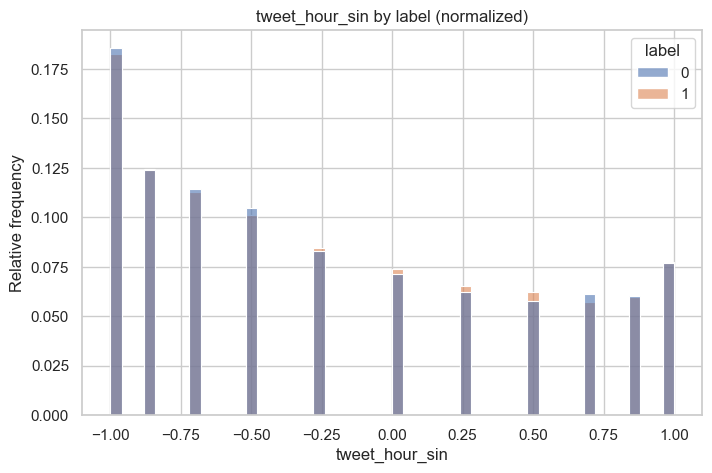

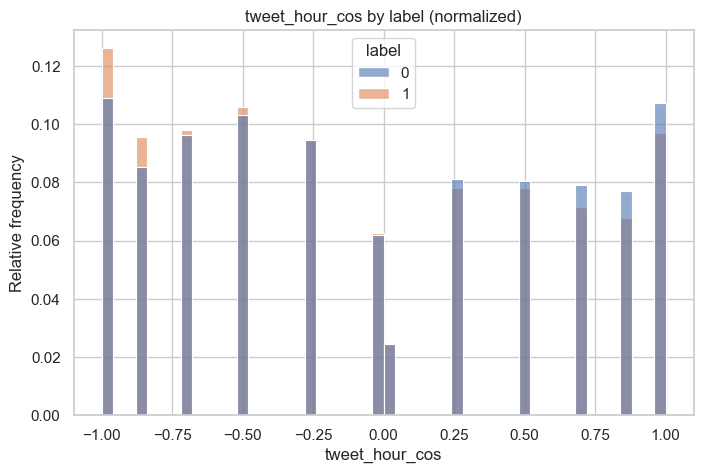

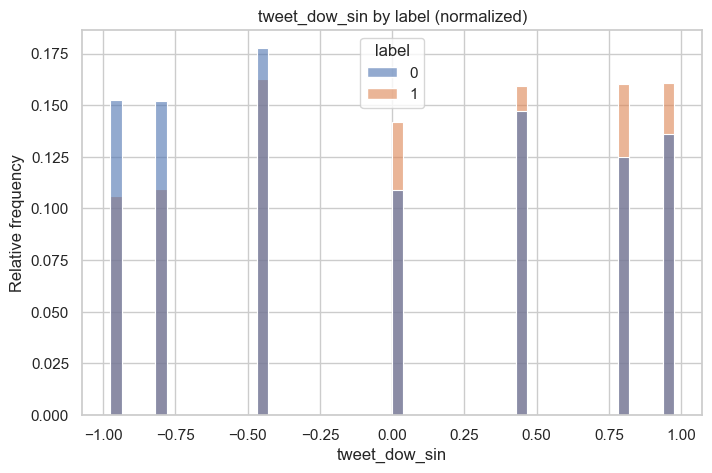

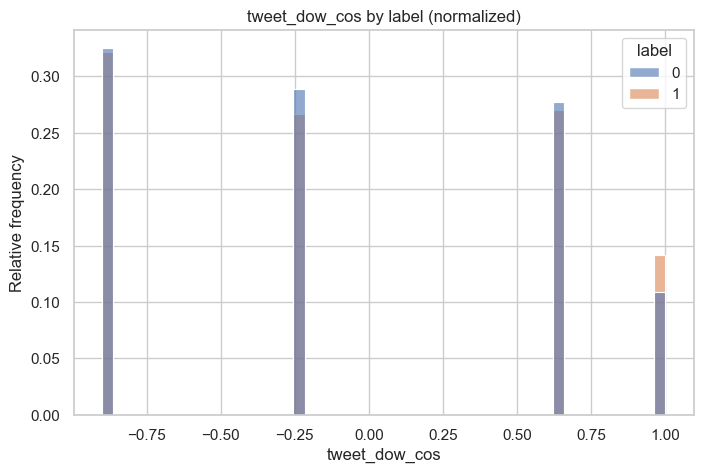

In [18]:
numeric_cols = ["tweet_hour_sin", "tweet_hour_cos", "tweet_dow_sin", "tweet_dow_cos"]

for col in numeric_cols:
  df_plot = tweet_features[[col, 'label']].dropna(subset=[col])
  plot_numeric(df_plot, col)

In [ ]:
import joblib

joblib.dump(tweet_features, f"../../02_data/tweet_features_2.joblib")